In [11]:
# Copyright (c) Meta Platforms, Inc. and affiliates. All rights reserved.

# Fit a volume via raymarching
通过光线行进调整体积

This tutorial shows how to fit a volume given a set of views of a scene using differentiable volumetric rendering.

More specifically, this tutorial will explain how to:
1. Create a differentiable volumetric renderer.
2. Create a Volumetric model (including how to use the `Volumes` class).
3. Fit the volume based on the images using the differentiable volumetric renderer. 
4. Visualize the predicted volume.


本教程介绍如何使用可微体积渲染在给定场景的一组视图的情况下调整体积。

更具体地说，本教程将解释如何：
1. 创建可微分体积渲染器。
2. 创建一个体积模型（包括如何使用“体积”类）。
3. 使用可微体积渲染器根据图像调整体积。
4. 可视化预测的交易量。

## 0. Install and Import modules
Ensure `torch` and `torchvision` are installed. If `pytorch3d` is not installed, install it using the following cell:

In [12]:
import os
import sys
import torch
need_pytorch3d=False
try:
    import pytorch3d
except ModuleNotFoundError:
    need_pytorch3d=True
if need_pytorch3d:
    if torch.__version__.startswith(("1.13.", "2.0.")) and sys.platform.startswith("linux"):
        # We try to install PyTorch3D via a released wheel.
        pyt_version_str=torch.__version__.split("+")[0].replace(".", "")
        version_str="".join([
            f"py3{sys.version_info.minor}_cu",
            torch.version.cuda.replace(".",""),
            f"_pyt{pyt_version_str}"
        ])
        !pip install fvcore iopath
        !pip install --no-index --no-cache-dir pytorch3d -f https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/{version_str}/download.html
    else:
        # We try to install PyTorch3D from source.
        !pip install 'git+https://github.com/facebookresearch/pytorch3d.git@stable'

In [13]:
import os
import sys
import time
import json
import glob
import torch
import math
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from IPython import display

# Data structures and functions for rendering
from pytorch3d.structures import Volumes
from pytorch3d.renderer import (
    FoVPerspectiveCameras, 
    VolumeRenderer,
    NDCMultinomialRaysampler,
    EmissionAbsorptionRaymarcher
)
from pytorch3d.transforms import so3_exp_map

# obtain the utilized device
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.cuda.set_device(device)
else:
    device = torch.device("cpu")

In [14]:
# !wget https://raw.githubusercontent.com/facebookresearch/pytorch3d/main/docs/tutorials/utils/plot_image_grid.py
# !wget https://raw.githubusercontent.com/facebookresearch/pytorch3d/main/docs/tutorials/utils/generate_cow_renders.py
# from plot_image_grid import image_grid
# from generate_cow_renders import generate_cow_renders

OR if running locally uncomment and run the following cell:

In [15]:
from utils.generate_cow_renders import generate_cow_renders
from utils import image_grid

## 1. Generate images of the scene and masks
1.生成场景和蒙版的图像

The following cell generates our training data.
It renders the cow mesh from the `fit_textured_mesh.ipynb` tutorial from several viewpoints and returns:
1. A batch of image and silhouette tensors that are produced by the cow mesh renderer.
2. A set of cameras corresponding to each render.

Note: For the purpose of this tutorial, which aims at explaining the details of volumetric rendering, we do not explain how the mesh rendering, implemented in the `generate_cow_renders` function, works. Please refer to `fit_textured_mesh.ipynb` for a detailed explanation of mesh rendering.
以下单元格生成我们的训练数据。
它从多个视点渲染“fit_textured_mesh.ipynb”教程中的奶牛网格并返回：
1. 一批由奶牛网格渲染器生成的图像和剪影张量。
2. 对应于每个渲染的一组摄像机。

注意：本教程旨在解释体积渲染的细节，我们不解释在“generate_cow_renders”函数中实现的网格渲染是如何工作的。请参阅“fit_textured_mesh.ipynb”以获取网格渲染的详细说明。

In [16]:
target_cameras, target_images, target_silhouettes = generate_cow_renders(num_views=40)
from PIL import Image
import numpy as np
img_idx = 0
save_image = target_images.clone()
save_image.cpu()
for  i in range(len(target_images)) :
    img_idx = img_idx + 1
    arr:np.ndarray =  save_image[i].cpu()
    print('arr.shape',arr.shape)
    arr = arr.numpy()*180 # 转换式
    img = Image.fromarray(arr.astype('uint8'))
    savepath = "./data/fit_textured_volume_target_images_"+str(img_idx) + ".png"
    img.save(savepath)
print(f'Generated {len(target_images)} images/silhouettes/cameras.')

arr.shape torch.Size([128, 128, 3])
arr.shape torch.Size([128, 128, 3])
arr.shape torch.Size([128, 128, 3])
arr.shape torch.Size([128, 128, 3])
arr.shape torch.Size([128, 128, 3])
arr.shape torch.Size([128, 128, 3])
arr.shape torch.Size([128, 128, 3])
arr.shape torch.Size([128, 128, 3])
arr.shape torch.Size([128, 128, 3])
arr.shape torch.Size([128, 128, 3])
arr.shape torch.Size([128, 128, 3])
arr.shape torch.Size([128, 128, 3])
arr.shape torch.Size([128, 128, 3])
arr.shape torch.Size([128, 128, 3])
arr.shape torch.Size([128, 128, 3])
arr.shape torch.Size([128, 128, 3])
arr.shape torch.Size([128, 128, 3])
arr.shape torch.Size([128, 128, 3])
arr.shape torch.Size([128, 128, 3])
arr.shape torch.Size([128, 128, 3])
arr.shape torch.Size([128, 128, 3])
arr.shape torch.Size([128, 128, 3])
arr.shape torch.Size([128, 128, 3])
arr.shape torch.Size([128, 128, 3])
arr.shape torch.Size([128, 128, 3])
arr.shape torch.Size([128, 128, 3])
arr.shape torch.Size([128, 128, 3])
arr.shape torch.Size([128, 1

## 2. Initialize the volumetric renderer
初始化体积渲染器
The following initializes a volumetric renderer that emits a ray from each pixel of a target image and samples a set of uniformly-spaced points along the ray. At each ray-point, the corresponding density and color value is obtained by querying the corresponding location in the volumetric model of the scene (the model is described & instantiated in a later cell).

下面初始化一个体积渲染器，该渲染器从目标图像的每个像素发射光线，并沿光线对一组均匀间隔的点进行采样。在每个光线点处，通过查询场景体积模型中的相应位置来获得相应的密度和颜色值（模型在后面的单元格中描述和实例化）。

The renderer is composed of a *raymarcher* and a *raysampler*.
- The *raysampler* is responsible for emitting rays from image pixels and sampling the points along them. Here, we use the `NDCMultinomialRaysampler` which follows the standard PyTorch3D coordinate grid convention (+X from right to left; +Y from bottom to top; +Z away from the user).
- The *raymarcher* takes the densities and colors sampled along each ray and renders each ray into a color and an opacity value of the ray's source pixel. Here we use the `EmissionAbsorptionRaymarcher` which implements the standard Emission-Absorption raymarching algorithm.

渲染器由一个 *raymarcher* 和一个 *raysampler* 组成。
- *光线采样器*负责从图像像素发射光线并沿它们采样点。在这里，我们使用“NDCMultinomialRaysampler”，它遵循标准的PyTorch3D坐标网格约定（+从右到左+X;从下到上+Y;远离用户+Z）。
- *raymarcher* 获取沿每条光线采样的密度和颜色，并将每条光线渲染为光线源像素的颜色和不透明度值。在这里，我们使用“EmissionAbtrorptionRaymarcher”，它实现了标准的Emission-Absorbraymarching算法。

In [17]:
# render_size describes the size of both sides of the 
# rendered images in pixels. We set this to the same size
# as the target images. I.e. we render at the same
# size as the ground truth images.
render_size = target_images.shape[1]

# Our rendered scene is centered around (0,0,0) 
# and is enclosed inside a bounding box
# whose side is roughly equal to 3.0 (world units).
volume_extent_world = 3.0

# 1) Instantiate the raysampler.
# Here, NDCMultinomialRaysampler generates a rectangular image
# grid of rays whose coordinates follow the PyTorch3D
# coordinate conventions.
# Since we use a volume of size 128^3, we sample n_pts_per_ray=150,
# which roughly corresponds to a one ray-point per voxel.
# We further set the min_depth=0.1 since there is no surface within
# 0.1 units of any camera plane.
raysampler = NDCMultinomialRaysampler(
    image_width=render_size,
    image_height=render_size,
    n_pts_per_ray=150,
    min_depth=0.1,
    max_depth=volume_extent_world,
)


# 2) Instantiate the raymarcher.
# Here, we use the standard EmissionAbsorptionRaymarcher 
# which marches along each ray in order to render
# each ray into a single 3D color vector 
# and an opacity scalar.
raymarcher = EmissionAbsorptionRaymarcher()

# Finally, instantiate the volumetric render
# with the raysampler and raymarcher objects.
renderer = VolumeRenderer(
    raysampler=raysampler, raymarcher=raymarcher,
)

## 3. Initialize the volumetric model 3.初始化体积模型

Next we instantiate a volumetric model of the scene. This quantizes the 3D space to cubical voxels, where each voxel is described with a 3D vector representing the voxel's RGB color and a density scalar which describes the opacity of the voxel (ranging between [0-1], the higher the more opaque).

接下来，我们实例化场景的体积模型。这会将 3D 空间量化为立方体素，其中每个体素都用代表体素 RGB 颜色的 3D 矢量和描述体素不透明度的密度标量描述（范围在 [0-1] 之间，越高越不透明）。

In order to ensure the range of densities and colors is between [0-1], we represent both volume colors and densities in the logarithmic space. During the forward function of the model, the log-space values are passed through the sigmoid function to bring the log-space values to the correct range.

Additionally, `VolumeModel` contains the renderer object. This object stays unaltered throughout the optimization.

In this cell we also define the `huber` loss function which computes the discrepancy between the rendered colors and masks.

为了确保密度和颜色的范围在 [0-1] 之间，我们在对数空间中表示体积颜色和密度。在模型的前向函数期间，对数空间值通过 sigmoid 函数传递，以使对数空间值达到正确的范围。

此外，“VolumeModel”包含渲染器对象。此对象在整个优化过程中保持不变。

在这个单元格中，我们还定义了“huber”损失函数，该函数计算渲染的颜色和蒙版之间的差异。

In [18]:
class VolumeModel(torch.nn.Module):
    def __init__(self, renderer, volume_size=[64] * 3, voxel_size=0.1):
        super().__init__()
        # After evaluating torch.sigmoid(self.log_colors), we get 
        # densities close to zero.
        self.log_densities = torch.nn.Parameter(-4.0 * torch.ones(1, *volume_size))
        # After evaluating torch.sigmoid(self.log_colors), we get 
        # a neutral gray color everywhere.
        self.log_colors = torch.nn.Parameter(torch.zeros(3, *volume_size))
        self._voxel_size = voxel_size
        # Store the renderer module as well.
        self._renderer = renderer
        
    def forward(self, cameras):
        batch_size = cameras.R.shape[0]

        # Convert the log-space values to the densities/colors
        densities = torch.sigmoid(self.log_densities)
        colors = torch.sigmoid(self.log_colors)
        
        # Instantiate the Volumes object, making sure
        # the densities and colors are correctly
        # expanded batch_size-times.
        volumes = Volumes(
            densities = densities[None].expand(
                batch_size, *self.log_densities.shape),
            features = colors[None].expand(
                batch_size, *self.log_colors.shape),
            voxel_size=self._voxel_size,
        )
        
        # Given cameras and volumes, run the renderer
        # and return only the first output value 
        # (the 2nd output is a representation of the sampled
        # rays which can be omitted for our purpose).
        return self._renderer(cameras=cameras, volumes=volumes)[0]
    
# A helper function for evaluating the smooth L1 (huber) loss
# between the rendered silhouettes and colors.
def huber(x, y, scaling=0.1):
    diff_sq = (x - y) ** 2
    loss = ((1 + diff_sq / (scaling**2)).clamp(1e-4).sqrt() - 1) * float(scaling)
    return loss

## 4. Fit the volume 4.体素拟合

Here we carry out the volume fitting with differentiable rendering.

在这里，我们使用可微渲染进行体积拟合。


In order to fit the volume, we render it from the viewpoints of the `target_cameras`
and compare the resulting renders with the observed `target_images` and `target_silhouettes`.

The comparison is done by evaluating the mean huber (smooth-l1) error between corresponding
pairs of `target_images`/`rendered_images` and `target_silhouettes`/`rendered_silhouettes`.

为了适应体积，我们从“target_cameras”的角度渲染它
并将生成的渲染与观察到的“target_images”和“target_silhouettes”进行比较。

比较是通过评估相应的
成对的“target_images”/“rendered_images”和“target_silhouettes”/“rendered_silhouettes”。

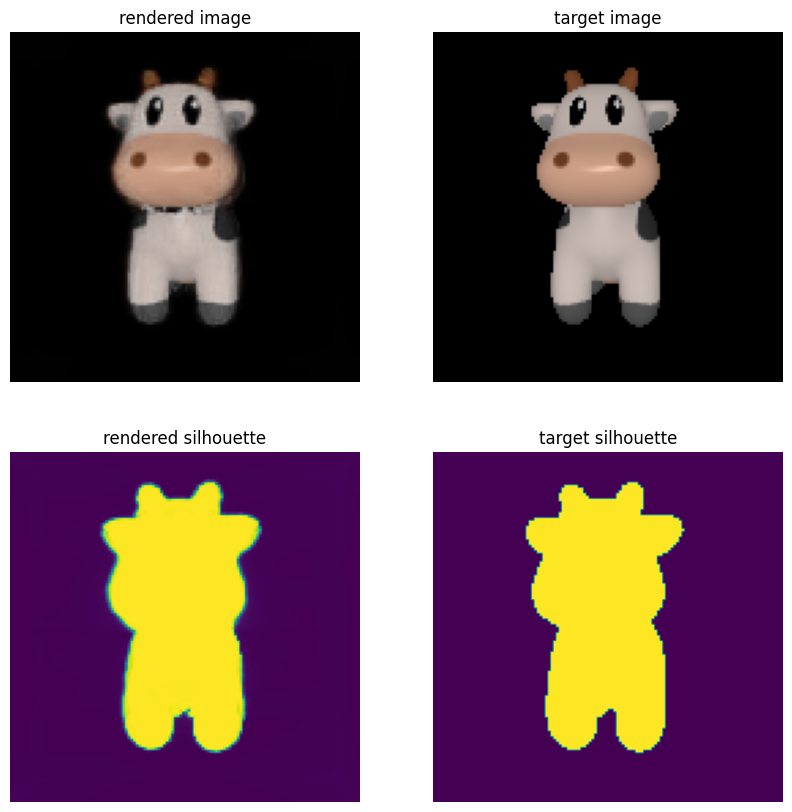

Iteration 00290: color_err = 3.94e-03 mask_err = 1.06e-02


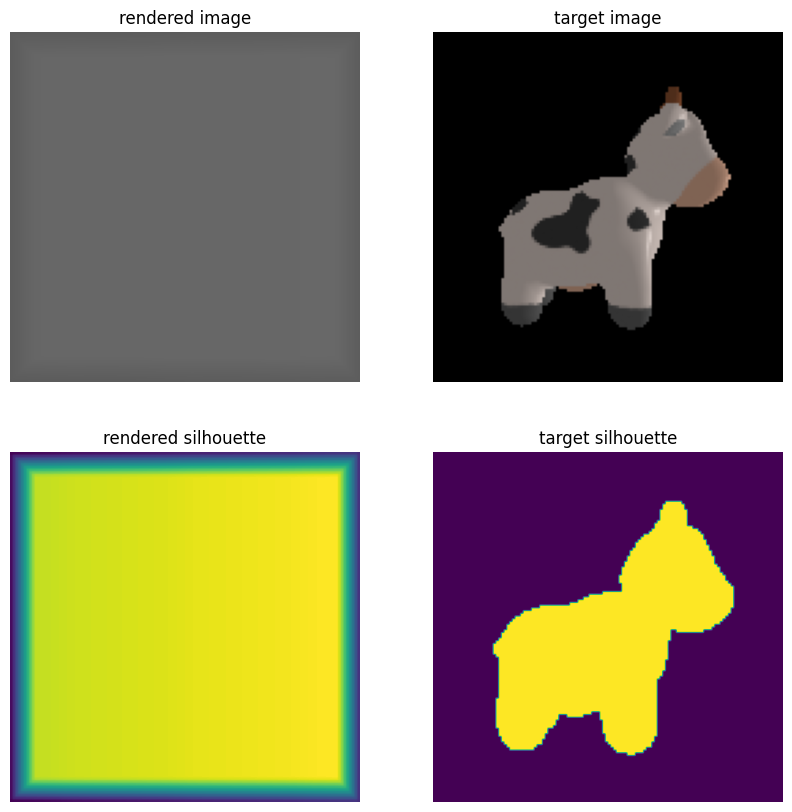

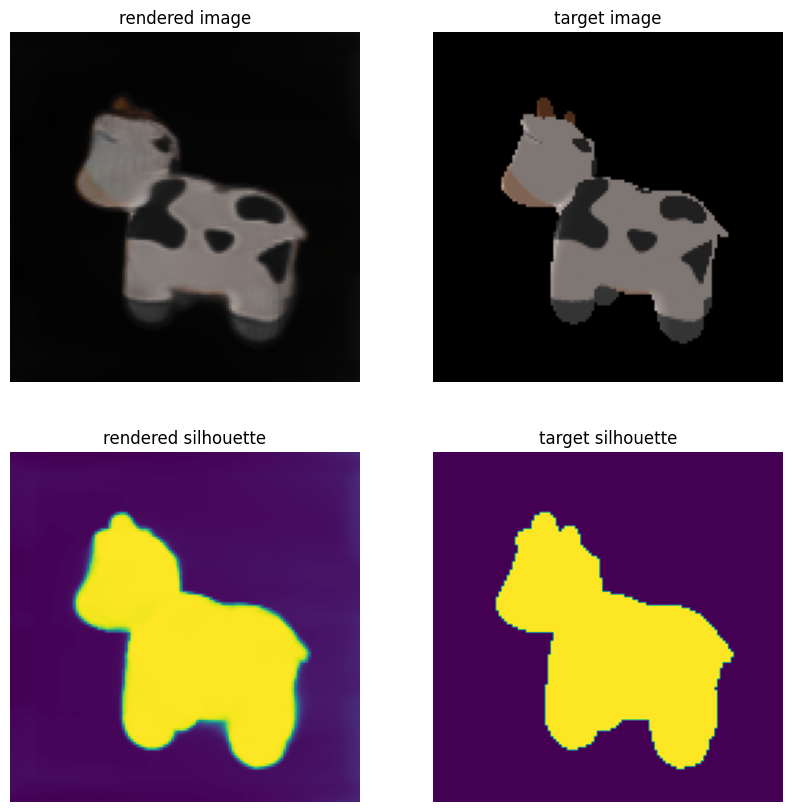

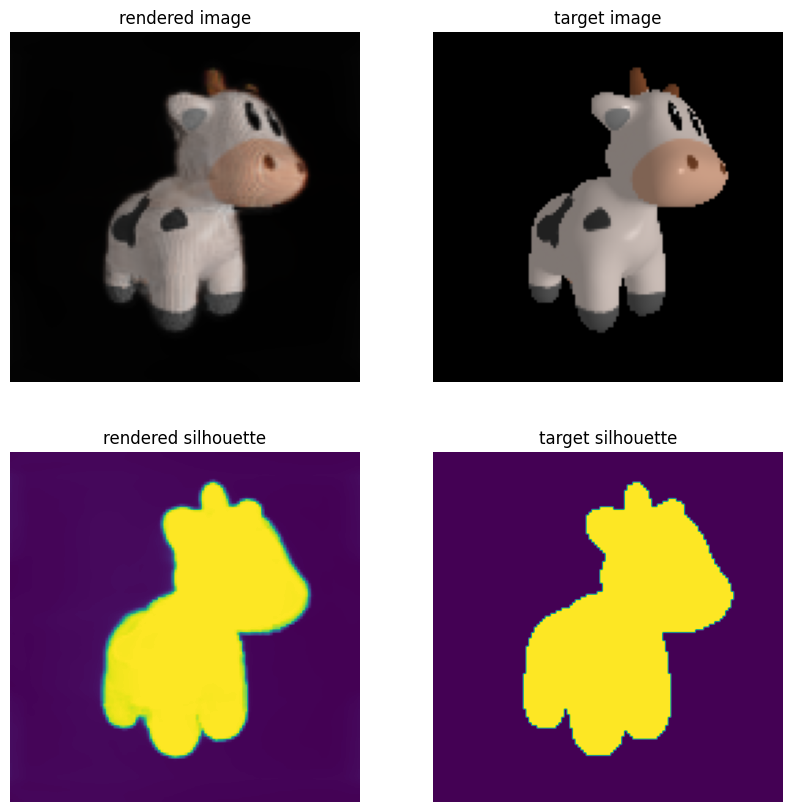

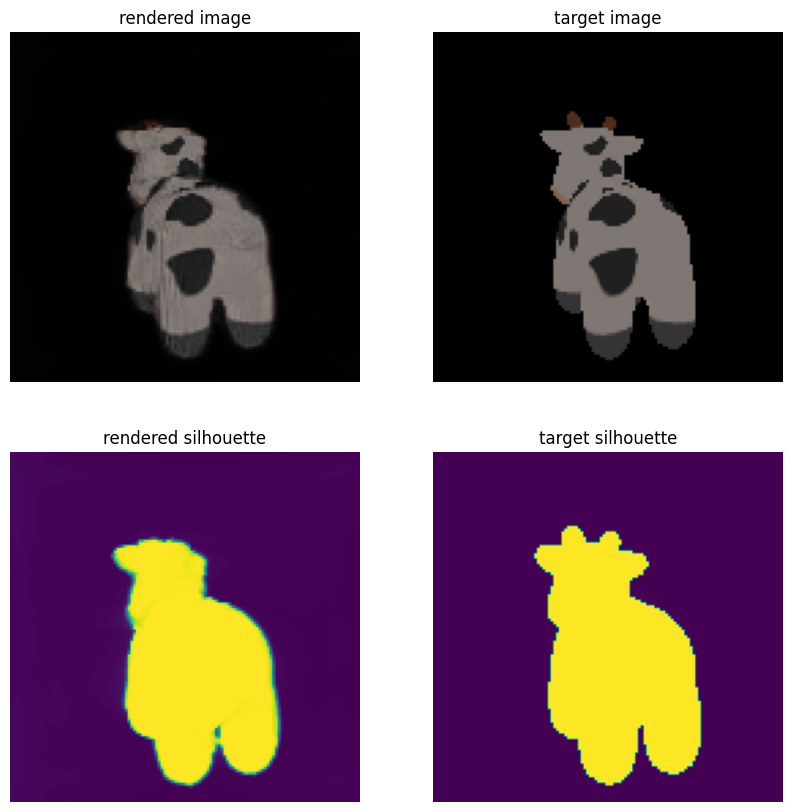

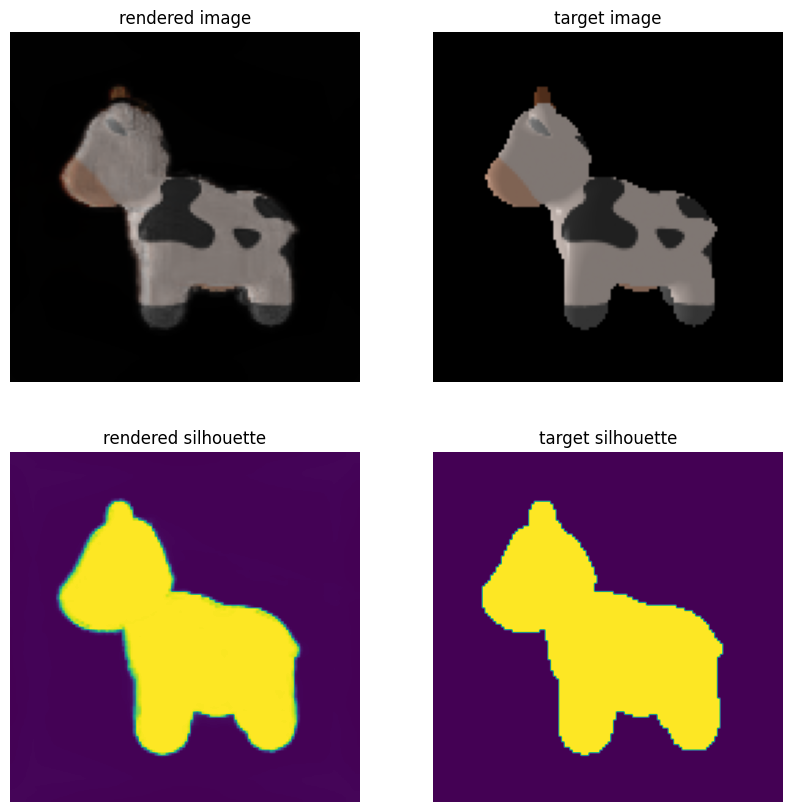

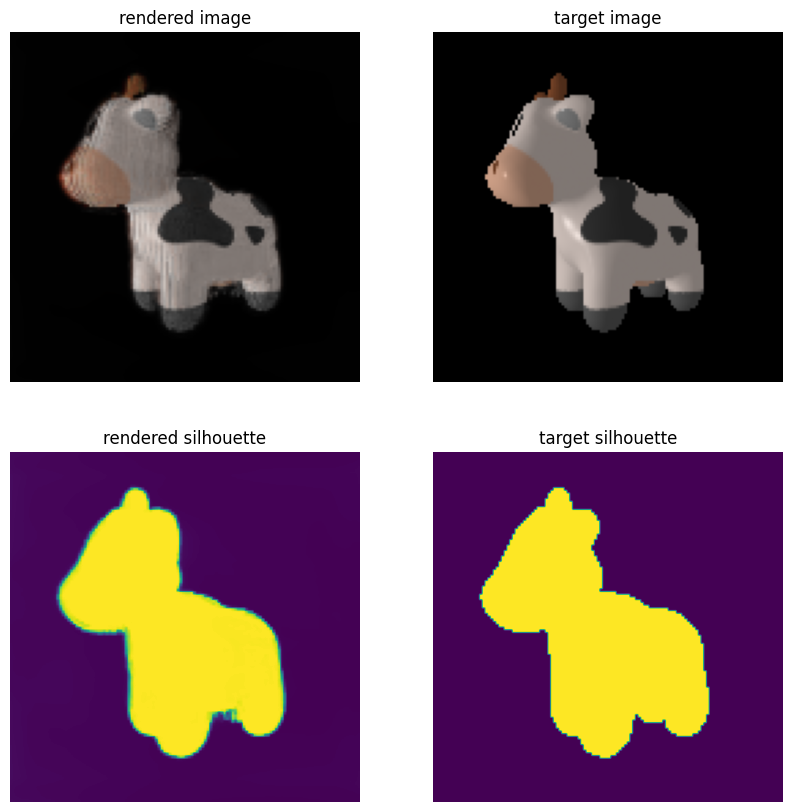

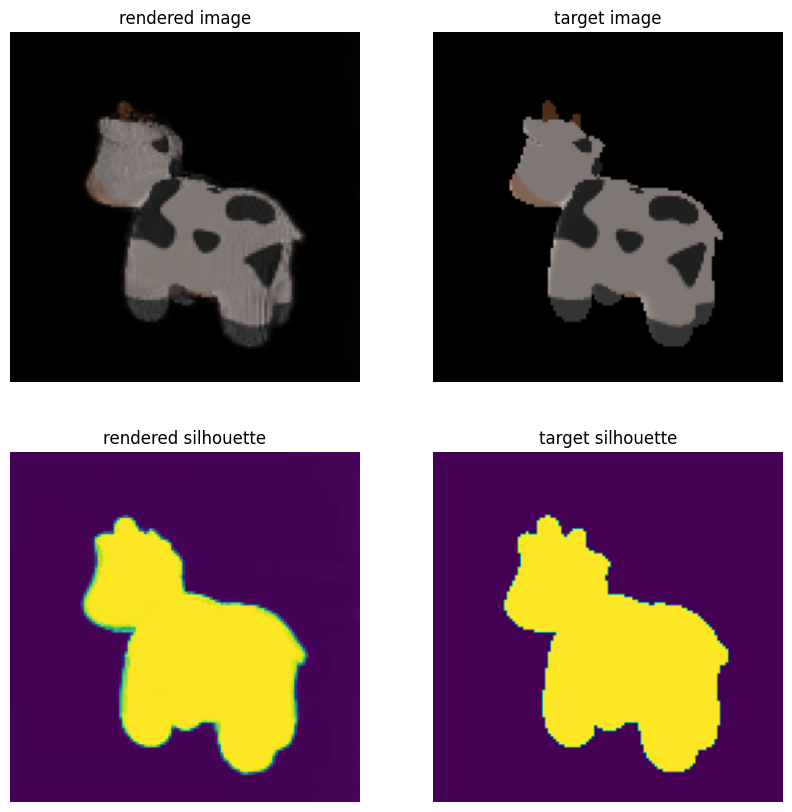

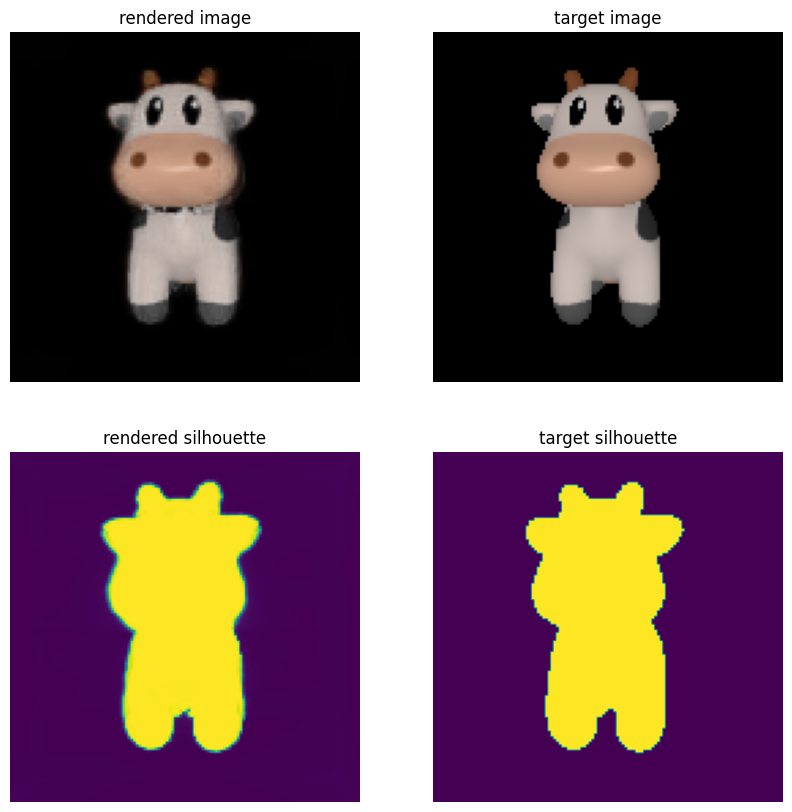

In [19]:
# First move all relevant variables to the correct device.
target_cameras = target_cameras.to(device)
target_images = target_images.to(device)
target_silhouettes = target_silhouettes.to(device)

# Instantiate the volumetric model.
# We use a cubical volume with the size of 
# one side = 128. The size of each voxel of the volume 
# is set to volume_extent_world / volume_size s.t. the
# volume represents the space enclosed in a 3D bounding box
# centered at (0, 0, 0) with the size of each side equal to 3.
volume_size = 128
volume_model = VolumeModel(
    renderer,
    volume_size=[volume_size] * 3, 
    voxel_size = volume_extent_world / volume_size,
).to(device)

# Instantiate the Adam optimizer. We set its master learning rate to 0.1.
lr = 0.1
optimizer = torch.optim.Adam(volume_model.parameters(), lr=lr)

# We do 300 Adam iterations and sample 10 random images in each minibatch.
batch_size = 10
n_iter = 300
for iteration in range(n_iter):

    # In case we reached the last 75% of iterations,
    # decrease the learning rate of the optimizer 10-fold.
    if iteration == round(n_iter * 0.75):
        print('Decreasing LR 10-fold ...')
        optimizer = torch.optim.Adam(
            volume_model.parameters(), lr=lr * 0.1
        )
    
    # Zero the optimizer gradient.
    optimizer.zero_grad()
    
    # Sample random batch indices.
    batch_idx = torch.randperm(len(target_cameras))[:batch_size]
    
    # Sample the minibatch of cameras.
    batch_cameras = FoVPerspectiveCameras(
        R = target_cameras.R[batch_idx], 
        T = target_cameras.T[batch_idx], 
        znear = target_cameras.znear[batch_idx],
        zfar = target_cameras.zfar[batch_idx],
        aspect_ratio = target_cameras.aspect_ratio[batch_idx],
        fov = target_cameras.fov[batch_idx],
        device = device,
    )
    
    # Evaluate the volumetric model.
    rendered_images, rendered_silhouettes = volume_model(
        batch_cameras
    ).split([3, 1], dim=-1)
    
    # Compute the silhouette error as the mean huber
    # loss between the predicted masks and the
    # target silhouettes.
    sil_err = huber(
        rendered_silhouettes[..., 0], target_silhouettes[batch_idx],
    ).abs().mean()

    # Compute the color error as the mean huber
    # loss between the rendered colors and the
    # target ground truth images.
    color_err = huber(
        rendered_images, target_images[batch_idx],
    ).abs().mean()
    
    # The optimization loss is a simple
    # sum of the color and silhouette errors.
    loss = color_err + sil_err 
    
    # Print the current values of the losses.
    if iteration % 10 == 0:
        print(
            f'Iteration {iteration:05d}:'
            + f' color_err = {float(color_err):1.2e}'
            + f' mask_err = {float(sil_err):1.2e}'
        )
    
    # Take the optimization step.
    loss.backward()
    optimizer.step()
    
    # Visualize the renders every 40 iterations.
    if iteration % 40 == 0:
        # Visualize only a single randomly selected element of the batch.
        im_show_idx = int(torch.randint(low=0, high=batch_size, size=(1,)))
        fig, ax = plt.subplots(2, 2, figsize=(10, 10))
        ax = ax.ravel()
        clamp_and_detach = lambda x: x.clamp(0.0, 1.0).cpu().detach().numpy()
        ax[0].imshow(clamp_and_detach(rendered_images[im_show_idx]))
        ax[1].imshow(clamp_and_detach(target_images[batch_idx[im_show_idx], ..., :3]))
        ax[2].imshow(clamp_and_detach(rendered_silhouettes[im_show_idx, ..., 0]))
        ax[3].imshow(clamp_and_detach(target_silhouettes[batch_idx[im_show_idx]]))
        for ax_, title_ in zip(
            ax, 
            ("rendered image", "target image", "rendered silhouette", "target silhouette")
        ):
            ax_.grid("off")
            ax_.axis("off")
            ax_.set_title(title_)
        fig.canvas.draw(); fig.show()
        display.clear_output(wait=True)
        display.display(fig)

## 5. Visualizing the optimized volume
5.可视化优化的体积

Finally, we visualize the optimized volume by rendering from multiple viewpoints that rotate around the volume's y-axis.

最后，我们通过从围绕体积 y 轴旋转的多个视点渲染来可视化优化的体积。

Generating rotating volume ...


  0%|          | 0/28 [00:00<?, ?it/s]

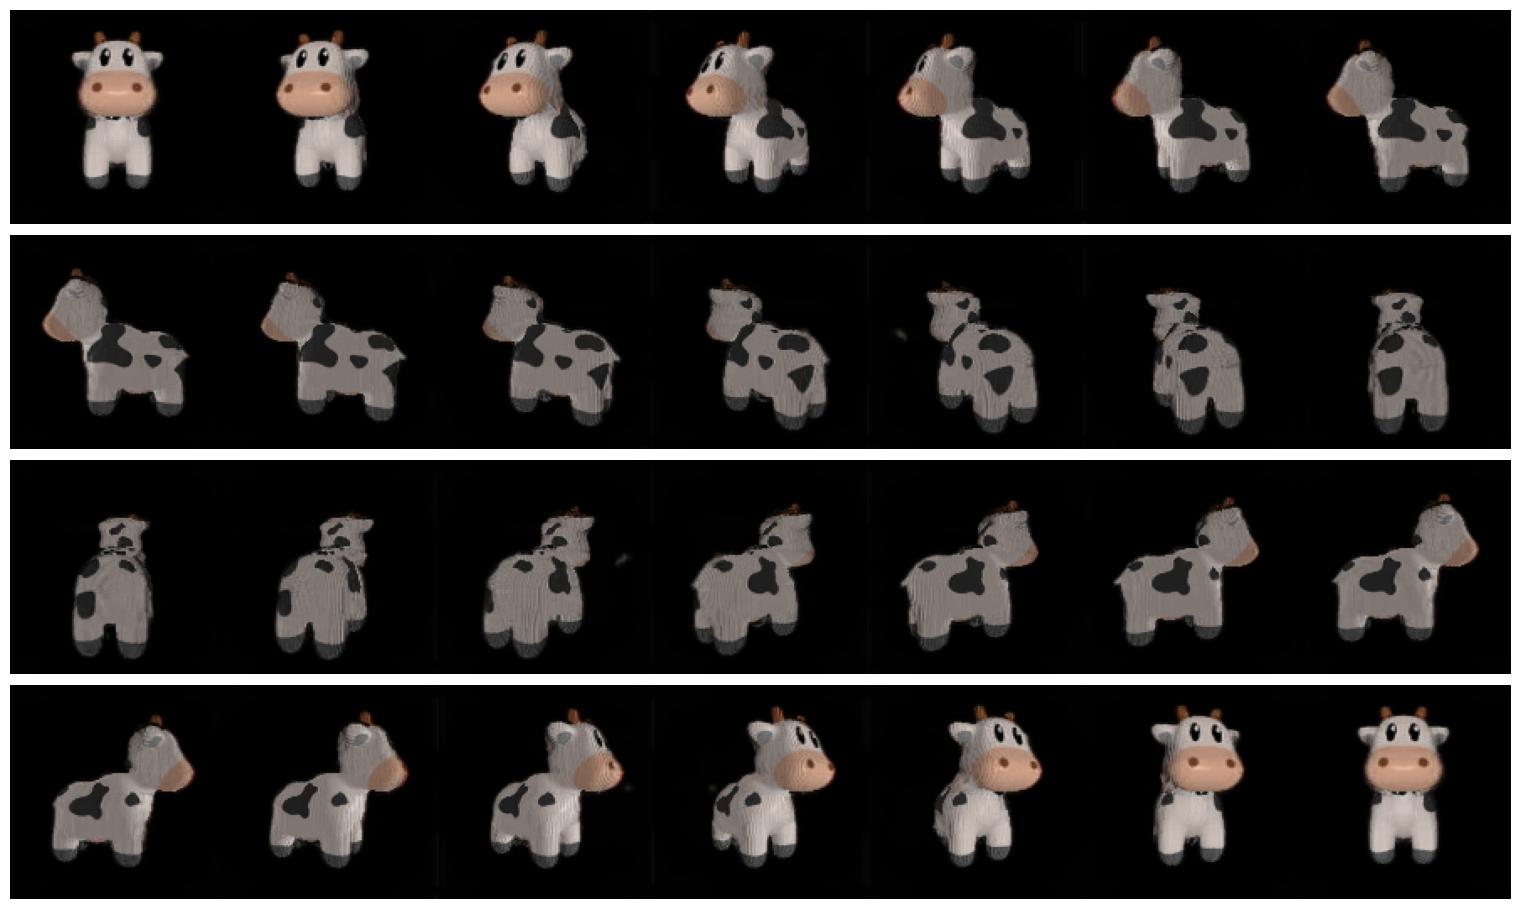

In [20]:
def generate_rotating_volume(volume_model, n_frames = 50):
    logRs = torch.zeros(n_frames, 3, device=device)
    logRs[:, 1] = torch.linspace(0.0, 2.0 * 3.14, n_frames, device=device)
    Rs = so3_exp_map(logRs)
    Ts = torch.zeros(n_frames, 3, device=device)
    Ts[:, 2] = 2.7
    frames = []
    print('Generating rotating volume ...')
    for R, T in zip(tqdm(Rs), Ts):
        camera = FoVPerspectiveCameras(
            R=R[None], 
            T=T[None], 
            znear = target_cameras.znear[0],
            zfar = target_cameras.zfar[0],
            aspect_ratio = target_cameras.aspect_ratio[0],
            fov = target_cameras.fov[0],
            device=device,
        )
        frames.append(volume_model(camera)[..., :3].clamp(0.0, 1.0))
    return torch.cat(frames)
    
with torch.no_grad():
    rotating_volume_frames = generate_rotating_volume(volume_model, n_frames=7*4)

image_grid(rotating_volume_frames.clamp(0., 1.).cpu().numpy(), rows=4, cols=7, rgb=True, fill=True)
plt.show()

## 6. Conclusion

In this tutorial, we have shown how to optimize a 3D volumetric representation of a scene such that the renders of the volume from known viewpoints match the observed images for each viewpoint. The rendering was carried out using the PyTorch3D's volumetric renderer composed of an `NDCMultinomialRaysampler` and an `EmissionAbsorptionRaymarcher`.

在本教程中，我们展示了如何优化场景的 3D 体积表示，以便来自已知视点的体积渲染与每个视点的观察到的图像相匹配。渲染是使用PyTorch3D的体积渲染器进行的，该渲染器由“NDCMultinomialRaysampler”和“EmissionAbabsorbrptionRaymarcher”组成。